In [102]:

%matplotlib inline
import numpy as np
import pylab as pl
import scipy.special as special
from scipy.integrate import quad,fixed_quad

# Set plot parameters to make beautiful plots
pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20  
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'large'

pl.rcParams['xtick.major.size'] = 8     
pl.rcParams['xtick.minor.size'] = 4     
pl.rcParams['xtick.major.pad']  = 8     
pl.rcParams['xtick.minor.pad']  = 8     
pl.rcParams['xtick.color']      = 'k'     
pl.rcParams['xtick.labelsize']  = 'large'
pl.rcParams['xtick.direction']  = 'in'    

pl.rcParams['ytick.major.size'] = 8     
pl.rcParams['ytick.minor.size'] = 4     
pl.rcParams['ytick.major.pad']  = 8     
pl.rcParams['ytick.minor.pad']  = 8     
pl.rcParams['ytick.color']      = 'k'     
pl.rcParams['ytick.labelsize']  = 'large'
pl.rcParams['ytick.direction']  = 'in'



In [103]:
# EVERYTHING IS 1 units

#constants
e        = 1.     #electron charge
m        = 1.     #electron mass
c        = 1.     #speed of light
epsilon0 = 1.     #permittivity of free space
epsilon  = -1.    #sign of electron charge

#parameters
B     = 1.         #background B strength
n_e   = 1.         #electron number density cm^-3
w_T   = 1.         #dimensionless electron temp. k_B T / m c^2
theta = np.pi / 3. #observer angle

#derived quantities
omega_p = np.sqrt(n_e * e**2. / (m * epsilon0))     # plasma frequency
omega_c = e * B / (m * c)                           # cyclotron frequency


In [104]:
#coding up the swanson tensor elements
#we first need the plasma dispersion function

def Z_integrand(xi, zeta):
    prefactor   = 1. / np.sqrt(np.pi)
    numerator   = np.exp(-xi**2.)
    
#   denominator = xi - zeta  #included in quad with weight type 'cauchy' passed to quad
    denominator = 1.
    
    return prefactor * numerator / denominator

def Zder_integrand(xi,zeta):
    prefactor = -1. / np.sqrt(np.pi)
    numerator = 2*xi*np.exp(-xi**2)
    denominator = 1
    return prefactor*numerator/denominator

def Zder(zeta):
#     if(np.abs(zeta) < 2.):
#         int_limit = 10. * np.abs(zeta)
#     elif(np.abs(zeta) > 2. and np.abs(zeta) < 130.):
#         int_limit = 2. * np.abs(zeta)
#     else:
#         int_limit = 1.5 * np.abs(zeta)
    
#     imag_part = 1j * np.pi * Zder_integrand(zeta, zeta)
    
#     if(zeta != 0):
#         ans = quad(lambda xi: Zder_integrand(xi, zeta), -int_limit, int_limit, weight='cauchy', wvar=zeta)[0]
#     else:
#         ans = 0.
        
#     return ans + imag_part
    return -2 * (1+zeta*Z(zeta))

#seems to work up to |zeta| = 625 where it's approx. -/+ 0.002 (so negative zeta yields +0.002)
def Z(zeta): 
    if(np.abs(zeta) < 2.):
        int_limit = 10. * np.abs(zeta)
    elif(np.abs(zeta) > 2. and np.abs(zeta) < 130.):
        int_limit = 2. * np.abs(zeta)
    else:
        int_limit = 1.5 * np.abs(zeta)
    
    imag_part = 1j * np.pi * Z_integrand(zeta, zeta)
    
    if(zeta != 0):
        ans = quad(lambda xi: Z_integrand(xi, zeta), -int_limit, int_limit, weight='cauchy', wvar=zeta)[0]
    else:
        ans = 0.
        
    return ans + imag_part


In [105]:
def K_2(n, omega):
    k_perp = omega / c * np.sin(theta)                  # wavevector perp component n = 1 approximation
    k_z    = omega / c * np.cos(theta)                  # wavevector parallel comp. n = 1 approximation
    lambd   = k_perp**2. * w_T**2. / (2. * omega_c**2.) # just a defined parameter
    prefactor = 1j * epsilon * omega_p**2. * np.exp(-lambd) / (omega * k_z * w_T)
    zeta = (omega + n * omega_c) / (k_z * w_T)
    
    if(np.abs(zeta) > 625):
        print ("zeta out of range of PDF")
    
    term1 = n * (special.iv(n, lambd) - special.ivp(n, lambd)) * Z(zeta)
    ans = prefactor * term1
    return ans

def K_2sum(terms,omega):
    ans = 0.
    for i in range(-terms, terms):
        ans += K_2(i, omega)
#        print i, ans  
    return ans


In [106]:
def K_0(n,omega):
    
    k_perp = omega / c * np.sin(theta)                  # wavevector perp component n = 1 approximation
    k_z    = omega / c * np.cos(theta)                  # wavevector parallel comp. n = 1 approximation
    lambd   = k_perp**2. * w_T**2. / (2. * omega_c**2.) # just a defined parameter
    zeta = (omega + n * omega_c) / (k_z * w_T)
    
    prefactor = 2*omega_p**2. * np.exp(-lambd) / (omega * k_z * w_T)
    
    if(np.abs(zeta) > 625):
        print ("zeta out of range of PDF")
        
    term1 = lambd * (special.iv(n,lambd) - special.ivp(n,lambd)) * Z(zeta)
    ans = prefactor * term1
    return ans

def K_0sum(terms,omega):
    ans = 0.
    for i in range(-terms, terms):
        ans += K_0(i, omega)
#        print i, ans  
    return ans


In [171]:
def K_1(n,omega):
    #can't add the 1 here, add it towards the end of calculating the component (in K_11(a,b))
    
    k_perp = omega / c * np.sin(theta)                  # wavevector perp component n = 1 approximation
    k_z    = omega / c * np.cos(theta)                  # wavevector parallel comp. n = 1 approximation
    lambd   = k_perp**2. * w_T**2. / (2. * omega_c**2.) # just a defined parameter
    zeta = (omega + n * omega_c) / (k_z * w_T)
        
    prefactor = omega_p**2. * np.exp(-lambd) / (omega * k_z * w_T)
    
#     if(np.abs(zeta) > 625):
#         print ("zeta out of range of PDF")
        
    term1 = n**2 * (special.iv(n,lambd)/lambd) * Z(zeta)
    ans = prefactor * term1
    return ans

def K_1sum(terms,omega):
    ans = 0.
    for i in range(-terms, terms):
        ans += K_1(i, omega)
#        print i, ans  
    return 1 + ans

In [108]:
def K_3(n,omega):
    #can't add 1 here, do it in the end (in K_33(a,b))
    k_perp = omega / c * np.sin(theta)                  # wavevector perp component n = 1 approximation
    k_z    = omega / c * np.cos(theta)                  # wavevector parallel comp. n = 1 approximation
    lambd   = k_perp**2. * w_T**2. / (2. * omega_c**2.) # just a defined parameter
    zeta = (omega + n * omega_c) / (k_z * w_T)
    
    prefactor = -1*omega_p**2. * np.exp(-lambd) / (omega * k_z * w_T)
    
#     if(np.abs(zeta) > 625):
#         print ("zeta out of range of PDF")
        
    term1 = special.iv(n,lambd) * zeta * Zder(zeta)
    ans = prefactor * term1
    return ans

def K_3sum(terms,omega):
    ans = 0.
    for i in range(-terms, terms):
        ans += K_3(i, omega)
#        print i, ans  
    return 1 + ans

In [109]:
def K_4(n,omega):
    
    k_perp = omega / c * np.sin(theta)                  # wavevector perp component n = 1 approximation
    k_z    = omega / c * np.cos(theta)                  # wavevector parallel comp. n = 1 approximation
    lambd   = k_perp**2. * w_T**2. / (2. * omega_c**2.) # just a defined parameter
    zeta = (omega + n * omega_c) / (k_z * w_T)
    
    prefactor = k_perp*omega_p**2. * np.exp(-lambd) / (2*omega * k_z * omega_c)
    
    if(np.abs(zeta) > 625):
        print ("zeta out of range of PDF")
        
    term1 = n*(special.iv(n,lambd)/lambd) * Zder(zeta)
    ans = prefactor * term1
    return ans

def K_4sum(terms,omega):
    ans = 0.
    for i in range(-terms, terms):
        ans += K_4(i, omega)
#        print i, ans  
    return ans

In [110]:
def K_5(n,omega):
    
    k_perp = omega / c * np.sin(theta)                  # wavevector perp component n = 1 approximation
    k_z    = omega / c * np.cos(theta)                  # wavevector parallel comp. n = 1 approximation
    lambd   = k_perp**2. * w_T**2. / (2. * omega_c**2.) # just a defined parameter
    zeta = (omega + n * omega_c) / (k_z * w_T)
    
    prefactor = 1j*k_perp*epsilon*omega_p**2. * np.exp(-lambd) / (2*omega * k_z * omega_c)
    
    if(np.abs(zeta) > 625):
        print ("zeta out of range of PDF")
        
    term1 = (special.iv(n,lambd) - special.ivp(n,lambd)) * Zder(zeta)
    ans = prefactor * term1
    return ans

def K_5sum(terms,omega):
    ans = 0.
    for i in range(-terms, terms):
        ans += K_5(i, omega)
#        print i, ans  
    return ans

In [111]:
#K_12
def swansK_12(terms, omega):
    return K_2sum(terms,omega)

#print K_12(number of sum terms evaluated, omega)

# print (swansK_12(100, 40.0) - swansK_12(10, 40.0))

In [112]:
#K_21 (simply negative of K_12)
def swansK_21(terms,omega):
    return -1*swansK_12(terms,omega)

# print(swansK_21(100,40.0) - swansK_21(10,40.0))

In [113]:
#K_11
def swansK_11(terms,omega):
    return K_1sum(terms,omega) - 1

# print(swansK_11(1000,40) - swansK_11(100, 40.0))

In [114]:
#K_22
def swansK_22(terms,omega):
    return K_1sum(terms,omega) + K_0sum(terms,omega) - 1
# print(swansK_22(1000,40.0) - swansK_22(100,40.0))

In [115]:
#K_33
def swansK_33(terms,omega):
    return K_3sum(terms,omega) - 1
# print(swansK_33(1000,40.0) - swansK_33(100,40.0))

In [116]:
#K_13
def swansK_13(terms,omega):
    return K_4sum(terms,omega)
# print(swansK_13(1000,40.0) - swansK_13(100,40.0))

In [117]:
#K_31 (simply the same as K_13)

def swansK_31(terms,omega):
    return swansK_13(terms,omega)

In [118]:
#K_23
def swansK_23(terms,omega):
    return -1*K_5sum(terms,omega)
    # print(swansK_23(1000,40.0) - swansK_23(100,40.0))

In [119]:
#K_32 (simply the negative of K_23)

def swansK_32(terms,omega):
    return -1*swansK_23(terms,omega)
# print(swansK_32(1000,40.0) - swansK_32(100,40.0))

In [120]:
#now to code all of our derived tensor components
#K_11
def K_11_integrand(tau,omega):
    k_perp = omega / c * np.sin(theta)# wavevector perp component n = 1 approximation
    k_z    = omega / c * np.cos(theta)# wavevector parellel component n = 1 approximation
    lambd   = k_perp**2. * w_T**2. / (2. * omega_c**2.) #predefined factor
    
    prefactor = -1j * omega_p**2 / (omega)
    taufactors = np.exp(1j*omega*tau) * np.exp(-2*lambd*(np.sin(epsilon*omega_c *tau/2))**2) * \
    np.exp(-(w_T)**2 * k_z**2 * (tau**2)/4)
    
    term1 = np.cos(epsilon * omega_c * tau) * (-1 + 2*lambd*(np.sin(epsilon* omega_c * tau/2))**2)
    term2 = 2*lambd*(np.sin(epsilon* omega_c * tau/2))**2
        
    return prefactor*taufactors*(term1 + term2)

def K_11(omega):
    K_11_real = quad(lambda tau: K_11_integrand(tau,omega).real,0,np.inf)
    K_11_imag = quad(lambda tau: K_11_integrand(tau,omega).imag,0,np.inf)
    return 0 + K_11_real[0] + 1j*K_11_imag[0]

In [121]:
#K_13
def K_13_integrand(tau,omega):
    k_perp = omega / c * np.sin(theta)# wavevector perp component n = 1 approximation
    k_z    = omega / c * np.cos(theta)# wavevector parellel component n = 1 approximation
    lambd   = k_perp**2. * w_T**2. / (2. * omega_c**2.) #predefined factor
    
    prefactor = 1j*omega_p**2 * k_perp * k_z * w_T**2 / (omega * epsilon * omega_c)
    taufactors = tau* np.exp(1j*omega*tau) * np.exp(-2*lambd*(np.sin(epsilon*omega_c *tau/2))**2) * \
    np.exp(-(w_T)**2 * k_z**2 * (tau**2)/4)
    
    term = np.sin(epsilon* omega_c * tau/2) * np.cos(epsilon* omega_c * tau/2)
    return prefactor * taufactors * term

def K_13(omega):
    K_13_real = quad(lambda tau: K_13_integrand(tau,omega).real,0,np.inf)
    K_13_imag = quad(lambda tau: K_13_integrand(tau,omega).imag,0,np.inf)
#     print(K_13_real)
#     print(K_13_imag)
    return K_13_real[0] + 1j*K_13_imag[0]

In [122]:
# K_31 is the same as K_13
def K_31(omega):
    return K_13(omega)

In [123]:
#K_23
def K_23_integrand(tau,omega):
    k_perp = omega / c * np.sin(theta)# wavevector perp component n = 1 approximation
    k_z    = omega / c * np.cos(theta)# wavevector parellel component n = 1 approximation
    lambd   = k_perp**2. * w_T**2. / (2. * omega_c**2.) #predefined factor
    
    prefactor = 1j*omega_p**2 * k_perp * k_z * w_T**2 / (omega * epsilon * omega_c)
    taufactors = tau* np.exp(1j*omega*tau) * np.exp(-2*lambd*(np.sin(epsilon*omega_c *tau/2))**2) * \
    np.exp(-(w_T)**2 * k_z**2 * (tau**2)/4)
    
    term = np.sin(epsilon* omega_c * tau/2)**2
    return prefactor * taufactors * term

def K_23(omega):
    K_23_real = quad(lambda tau: K_23_integrand(tau,omega).real,0,np.inf)
    K_23_imag = quad(lambda tau: K_23_integrand(tau,omega).imag,0,np.inf)
#     print(K_23_real)
#     print(K_23_imag)
    return K_23_real[0] + 1j*K_23_imag[0]
    

In [124]:
def K_32(omega):
    return -1*K_23(omega)

In [125]:
#K_33
def K_33_integrand(tau,omega):
    k_perp = omega / c * np.sin(theta)# wavevector perp component n = 1 approximation
    k_z    = omega / c * np.cos(theta)# wavevector parellel component n = 1 approximation
    lambd   = k_perp**2. * w_T**2. / (2. * omega_c**2.) #predefined factor

    prefactor = 1j*omega_p**2 / (2*omega)
    taufactors = np.exp(1j*omega*tau) * np.exp(-2*lambd*(np.sin(epsilon*omega_c *tau/2))**2) * \
    np.exp(-(w_T)**2 * k_z**2 * (tau**2)/4)
    
    term = 2- (w_T*k_z*tau)**2
    return prefactor*taufactors*term

def K_33(omega):
    K_33_real = quad(lambda tau: K_33_integrand(tau,omega).real,0,np.inf)
    K_33_imag = quad(lambda tau: K_33_integrand(tau,omega).imag,0,np.inf)
#     print(K_33_real)
#     print(K_33_imag)
    return 0 + K_33_real[0] + 1j*K_33_imag[0]

In [126]:
#K_22
def K_22_integrand(tau,omega):
    k_perp = omega / c * np.sin(theta)# wavevector perp component n = 1 approximation
    k_z    = omega / c * np.cos(theta)# wavevector parellel component n = 1 approximation
    lambd   = k_perp**2. * w_T**2. / (2. * omega_c**2.) #predefined factor
    
    prefactor = -1j * omega_p**2 / (omega)
    taufactors = np.exp(1j*omega*tau) * np.exp(-2*lambd*(np.sin(epsilon*omega_c *tau/2))**2) * \
    np.exp(-(w_T)**2 * k_z**2 * (tau**2)/4)
    
    term1 = np.cos(epsilon * omega_c * tau) * (-1 + 2*lambd*(np.sin(epsilon* omega_c * tau/2))**2)
    term2 = 2*lambd*(np.sin(epsilon* omega_c * tau/2))**2
    
    return prefactor* taufactors* (term1-term2)

def K_22(omega):
    K_22_real = quad(lambda tau: K_22_integrand(tau,omega).real,0,np.inf)
    K_22_imag = quad(lambda tau: K_22_integrand(tau,omega).imag,0,np.inf)
#     print(K_22_real)
#     print(K_22_imag)
    return 0 + K_22_real[0] + 1j*K_22_imag[0]

In [127]:
def numK_22_integrand(v_perp, v_z, tau, omega):
    minus_sign= -1. #why do we have this in this version but not the semianalytic one?
    prefactor = -2. * 1j * omega_p**2. / (w_T**5. * np.sqrt(np.pi) * omega)
    k_perp    = omega / c * np.sin(theta)                  # wavevector perp component n = 1 approximation
    k_z       = omega / c * np.cos(theta)                  # wavevector parallel comp. n = 1 approximation
    a         = omega - k_z * v_z
    term1     = np.exp(1j*a*tau) * v_perp**3. * np.exp(-(v_perp**2. + v_z**2.)/w_T**2.)
    term2     = special.jv(2,2. * k_perp * v_perp / (epsilon * omega_c) * np.sin(epsilon * omega_c * tau / 2.))
    term3     = np.cos(epsilon * omega_c * tau)*special.j0(2. * k_perp * v_perp / (epsilon * omega_c) * np.sin(epsilon * omega_c * tau / 2.))
    ans       = prefactor * term1 * (term2 + term3)
    return minus_sign * ans

def K_22_perp_integrated(v_z, tau, omega):
#    real_integral_result = quad(lambda v_perp: K_12_integrand(v_perp, v_z, tau, omega).real, 0., np.inf)
#    imag_integral_result = quad(lambda v_perp: K_12_integrand(v_perp, v_z, tau, omega).imag, 0., np.inf)
    real_integral_result = fixed_quad(lambda v_perp: numK_22_integrand(v_perp, v_z, tau, omega).real, 0., 20., 
                                     n=25) #huge speed improvement
    imag_integral_result = fixed_quad(lambda v_perp: numK_22_integrand(v_perp, v_z, tau, omega).imag, 0., 20., 
                                     n=25) #huge speed improvement
    ans = real_integral_result[0] + imag_integral_result[0] * 1j
    return ans

def K_22_v_integrated(tau, omega):
    real_integral_result = quad(lambda v_z: K_22_perp_integrated(v_z, tau, omega).real, -np.inf, np.inf)
    imag_integral_result = quad(lambda v_z: K_22_perp_integrated(v_z, tau, omega).imag, -np.inf, np.inf)
    ans = real_integral_result[0] + imag_integral_result[0] * 1j
    return ans

def numK_22(omega):
    real_integral_result = quad(lambda tau: K_22_v_integrated(tau, omega).real, 0., 20.) #setting upper bound
    imag_integral_result = quad(lambda tau: K_22_v_integrated(tau, omega).imag, 0., 20.) #by hand at the moment
    ans = real_integral_result[0] + imag_integral_result[0] * 1j
    return ans

In [128]:
#K_21
def K_21_integrand(tau,omega):
    k_perp = omega / c * np.sin(theta)# wavevector perp component n = 1 approximation
    k_z    = omega / c * np.cos(theta)# wavevector parellel component n = 1 approximation
    lambd   = k_perp**2. * w_T**2. / (2. * omega_c**2.) #predefined factor
    
    prefactor = 2j * omega_p**2 / (omega)
    taufactors = np.sin(epsilon*omega_c *tau)*np.exp(1j*omega*tau) * np.exp(-2*lambd*(np.sin(epsilon*omega_c *tau/2))**2) * \
    np.exp(-(w_T)**2 * k_z**2 * (tau**2)/4)
    
    term1 = lambd*(np.sin(epsilon* omega_c * tau/2))**2
    term2 = -1/2
        
    return prefactor*taufactors*(term1 + term2)

def K_21(omega):
    K_21_real = quad(lambda tau: K_21_integrand(tau,omega).real,0,np.inf)
    K_21_imag = quad(lambda tau: K_21_integrand(tau,omega).imag,0,np.inf)
    return K_21_real[0] + 1j*K_21_imag[0]

In [129]:
#K_12
def K_12_integrand(tau,omega):
    k_perp = omega / c * np.sin(theta)# wavevector perp component n = 1 approximation
    k_z    = omega / c * np.cos(theta)# wavevector parellel component n = 1 approximation
    lambd   = k_perp**2. * w_T**2. / (2. * omega_c**2.) #predefined factor
    
    prefactor = -1* 2j * omega_p**2 / (omega)
    taufactors = np.sin(epsilon*omega_c *tau)*np.exp(1j*omega*tau) * np.exp(-2*lambd*(np.sin(epsilon*omega_c *tau/2))**2) * \
    np.exp(-(w_T)**2 * k_z**2 * (tau**2)/4)
    
    term1 = lambd*(np.sin(epsilon* omega_c * tau/2))**2
    term2 = -1/2
        
    return prefactor*taufactors*(term1 + term2)

def K_12(omega):
    K_12_real = quad(lambda tau: K_12_integrand(tau,omega).real,0,np.inf)
    K_12_imag = quad(lambda tau: K_12_integrand(tau,omega).imag,0,np.inf)
    return K_12_real[0] + 1j*K_12_imag[0]

In [132]:
def numK_13_integrand(v_perp, v_z, tau, omega):
#     minus_sign= -1. #why do we have this in this version but not the semianalytic one?
    prefactor = -4. * omega_p**2. / (w_T**5. * np.sqrt(np.pi) * omega)
    k_perp    = omega / c * np.sin(theta)                  # wavevector perp component n = 1 approximation
    k_z       = omega / c * np.cos(theta)                  # wavevector parallel comp. n = 1 approximation
    a         = omega - k_z * v_z
    term1     = np.exp(1j*a*tau) * np.cos(epsilon * omega_c * tau/2) * np.exp(-(v_perp**2. + v_z**2.)/w_T**2.)
    term2     = special.j1(2. * k_perp * (v_perp / (epsilon * omega_c)) * np.sin(epsilon * omega_c * tau / 2.))
    term3     = v_perp**2. * v_z
    ans       = prefactor * term1 * term2 * term3
    return ans

def K_13_perp_integrated(v_z, tau, omega):
#    real_integral_result = quad(lambda v_perp: K_12_integrand(v_perp, v_z, tau, omega).real, 0., np.inf)
#    imag_integral_result = quad(lambda v_perp: K_12_integrand(v_perp, v_z, tau, omega).imag, 0., np.inf)
    real_integral_result = fixed_quad(lambda v_perp: numK_13_integrand(v_perp, v_z, tau, omega).real, 0., 20., 
                                     n=25) #huge speed improvement
    imag_integral_result = fixed_quad(lambda v_perp: numK_13_integrand(v_perp, v_z, tau, omega).imag, 0., 20., 
                                     n=25) #huge speed improvement
    ans = real_integral_result[0] + imag_integral_result[0] * 1j
    return ans

def K_13_v_integrated(tau, omega):
    real_integral_result = quad(lambda v_z: K_13_perp_integrated(v_z, tau, omega).real, -np.inf, np.inf)
    imag_integral_result = quad(lambda v_z: K_13_perp_integrated(v_z, tau, omega).imag, -np.inf, np.inf)
    ans = real_integral_result[0] + imag_integral_result[0] * 1j
    return ans

def numK_13(omega):
    real_integral_result = quad(lambda tau: K_13_v_integrated(tau, omega).real, 0., 20.) #setting upper bound
    imag_integral_result = quad(lambda tau: K_13_v_integrated(tau, omega).imag, 0., 20.) #by hand at the moment
    ans = real_integral_result[0] + imag_integral_result[0] * 1j
    return ans

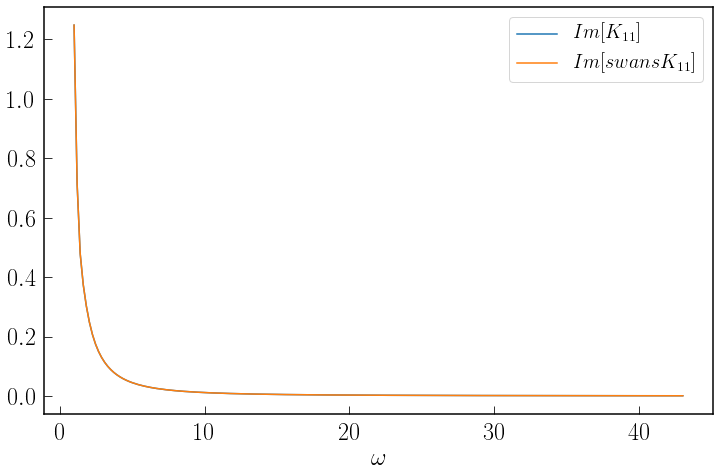

In [252]:
omegaVals = np.linspace(1,43,200)

pl.figure(0)
pl.plot(omegaVals,np.vectorize(K_11)(omegaVals).imag, label = '$Im[K_{11}]$')
pl.plot(omegaVals,np.vectorize(swansK_11)(100,omegaVals).imag, label = "$Im[swansK_{11}]$")
# pl.plot(omegaVals,omegaVals,label = 'imag')
pl.xlabel('$\omega$')
pl.legend(loc = "upper right")

KeyboardInterrupt: 

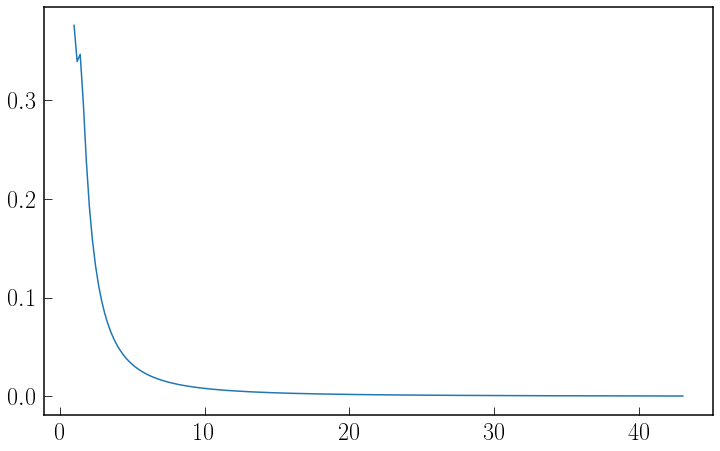

In [250]:
omegaVals = np.linspace(1,43,200)

pl.figure(0)
pl.plot(omegaVals,np.vectorize(K_33)(omegaVals).imag, label = '$Re[K_{33}]$')
pl.plot(omegaVals,np.vectorize(swansK_33)(100,omegaVals).imag, label = "$Re[swansK_{33}]$")
# pl.plot(omegaVals,omegaVals,label = 'imag')
pl.xlabel('$\omega$')
pl.legend(loc = "lower right")

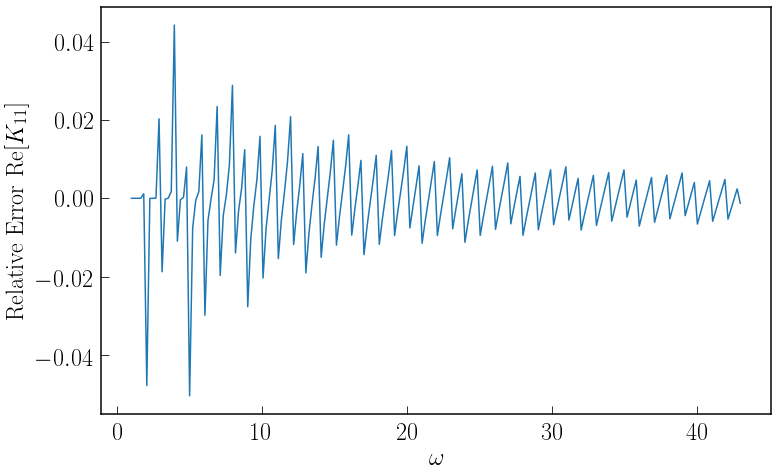

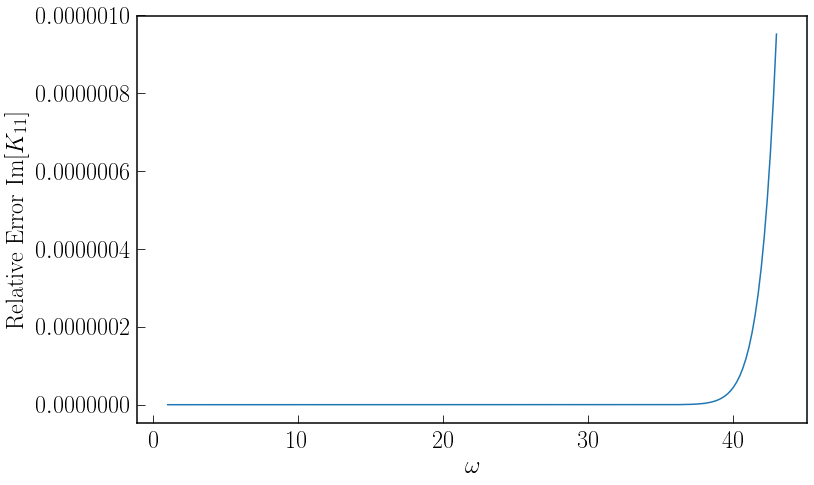

In [235]:
#Plotting Components vs omega
omegaVals = np.linspace(1,43,200)

pl.figure(0)
pl.plot(omegaVals,(np.vectorize(K_11)(omegaVals).real - np.vectorize(swansK_11)(100,omegaVals).real) \
        /np.vectorize(K_11)(omegaVals).real, label = '')
# pl.plot(omegaVals,omegaVals,label = 'imag')
pl.xlabel(r'$\omega$')
pl.ylabel("Relative Error "'Re[$K_{11}$]')

pl.figure(1)
pl.plot(omegaVals,(np.vectorize(K_11)(omegaVals).imag - np.vectorize(swansK_11)(100,omegaVals).imag) \
        /np.vectorize(K_11)(omegaVals).imag)
# pl.plot(omegaVals,omegaVals,label = 'imag')
pl.xlabel(r'$\omega$')
pl.ylabel("Relative Error "'Im[$K_{11}$]')
# pl.plot(omegaVals,np.vectorize(swansK_11)(100,omegaVals).real)

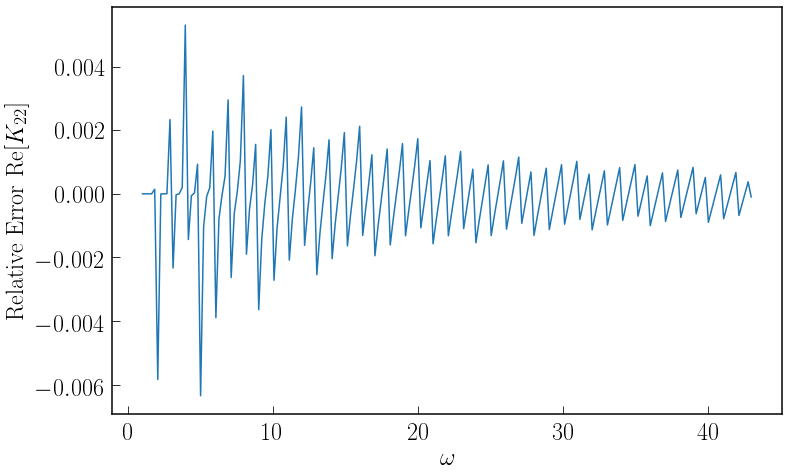

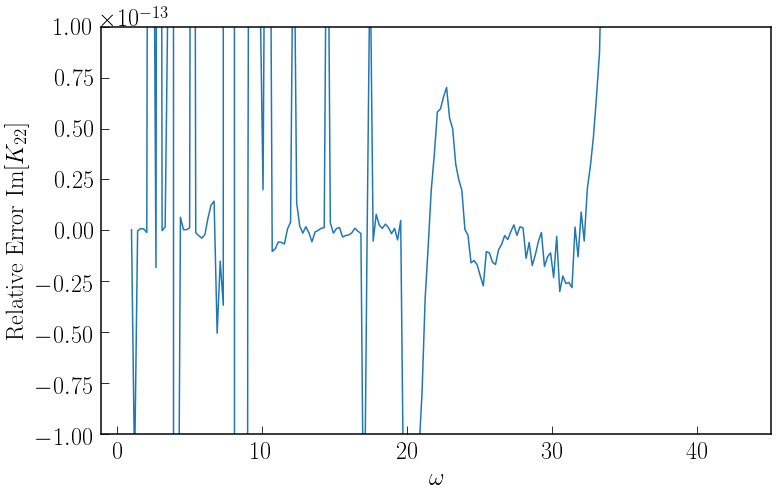

In [239]:
omegaVals = np.linspace(1,43,200)

pl.figure(0)
pl.plot(omegaVals,(np.vectorize(K_22)(omegaVals).real - np.vectorize(swansK_22)(100,omegaVals).real) \
        /np.vectorize(K_22)(omegaVals).real)
# pl.plot(omegaVals,omegaVals,label = 'imag')
pl.xlabel(r'$\omega$')
pl.ylabel("Relative Error "'Re[$K_{22}$]')

pl.figure(1)
pl.plot(omegaVals,(np.vectorize(K_22)(omegaVals).imag - np.vectorize(swansK_22)(100,omegaVals).imag) \
        /np.vectorize(K_22)(omegaVals).imag)
# pl.plot(omegaVals,omegaVals,label = 'imag')
pl.ylim([-1e-13,1e-13])
pl.xlabel(r'$\omega$')
pl.ylabel("Relative Error "'Im[$K_{22}$]')

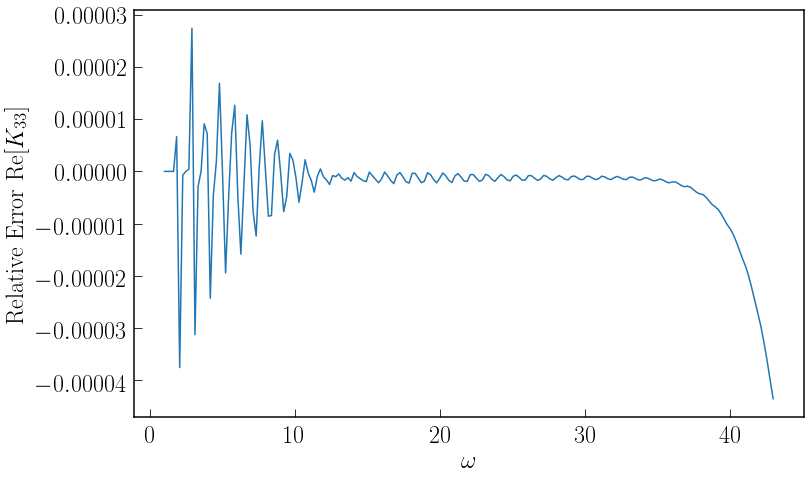

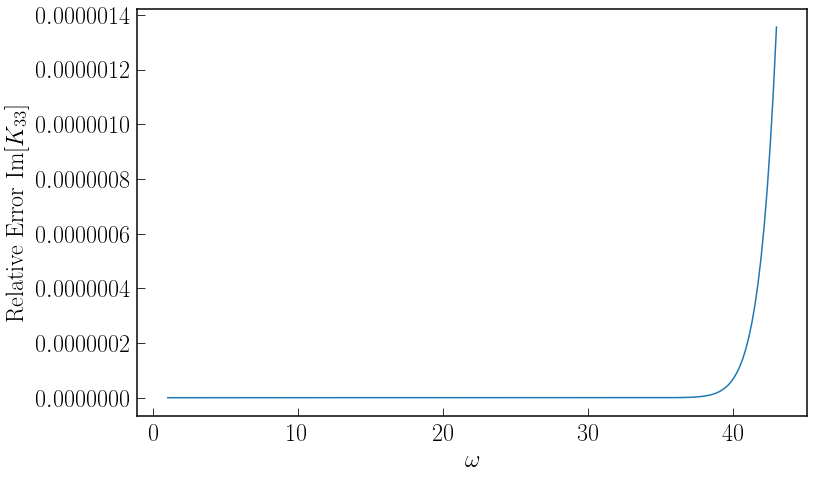

In [232]:
omegaVals = np.linspace(1,43,200)

pl.figure(0)
pl.plot(omegaVals,(np.vectorize(K_33)(omegaVals).real - np.vectorize(swansK_33)(100,omegaVals).real) \
        /np.vectorize(K_33)(omegaVals).real)
# pl.plot(omegaVals,omegaVals,label = 'imag')
pl.xlabel(r'$\omega$')
pl.ylabel("Relative Error "'Re[$K_{33}$]')

pl.figure(1)
pl.plot(omegaVals,(np.vectorize(K_33)(omegaVals).imag - np.vectorize(swansK_33)(100,omegaVals).imag) \
        /np.vectorize(K_33)(omegaVals).imag)
# pl.plot(omegaVals,omegaVals,label = 'imag')
pl.xlabel(r'$\omega$')
pl.ylabel("Relative Error "'Im[$K_{33}$]')

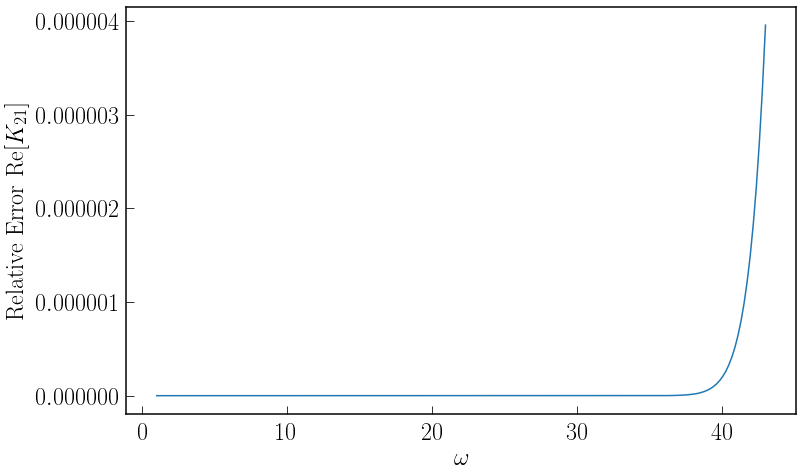

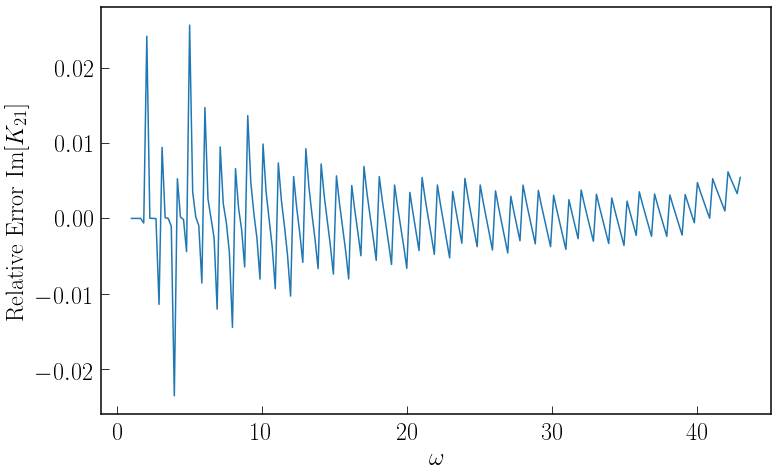

In [233]:
omegaVals = np.linspace(1,43,200)

pl.figure(0)
pl.plot(omegaVals,(np.vectorize(K_21)(omegaVals).real - np.vectorize(swansK_21)(100,omegaVals).real) \
        /np.vectorize(K_21)(omegaVals).real)
# pl.plot(omegaVals,omegaVals,label = 'imag')
pl.xlabel(r'$\omega$')
pl.ylabel("Relative Error "'Re[$K_{21}$]')

pl.figure(1)
pl.plot(omegaVals,(np.vectorize(K_21)(omegaVals).imag - np.vectorize(swansK_21)(100,omegaVals).imag) \
        /np.vectorize(K_21)(omegaVals).imag)
# pl.plot(omegaVals,omegaVals,label = 'imag')
pl.xlabel(r'$\omega$')
pl.ylabel("Relative Error "'Im[$K_{21}$]')

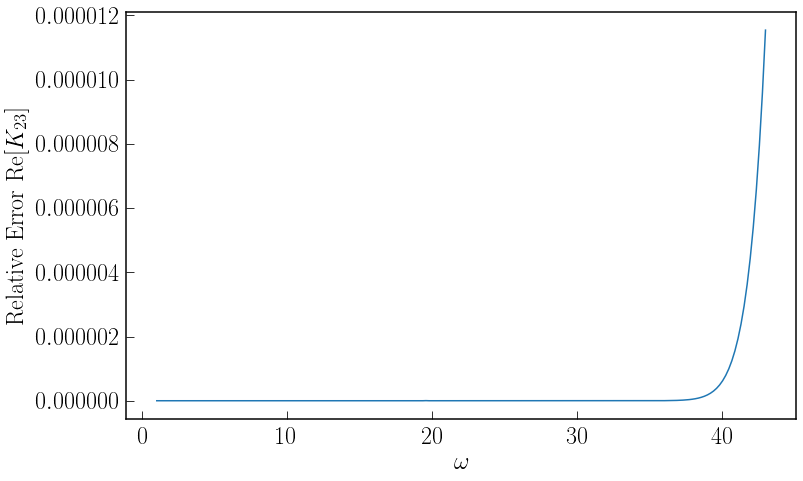

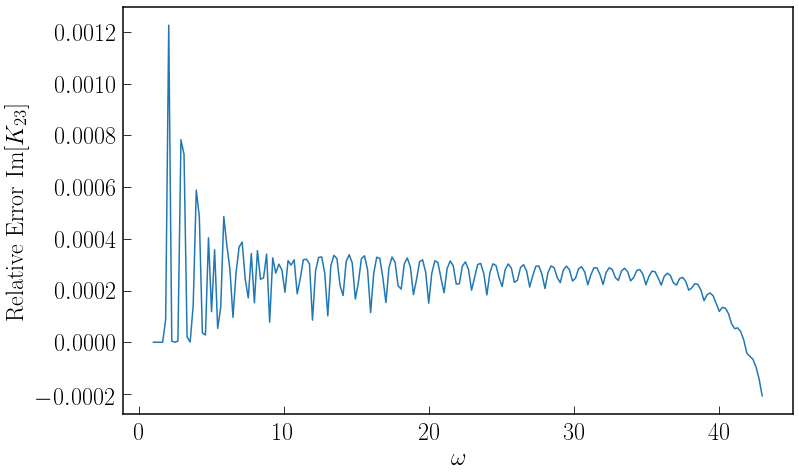

In [236]:
omegaVals = np.linspace(1,43,200)

pl.figure(0)
pl.plot(omegaVals,(np.vectorize(K_23)(omegaVals).real - np.vectorize(swansK_23)(100,omegaVals).real) \
        /np.vectorize(K_23)(omegaVals).real)
# pl.plot(omegaVals,omegaVals,label = 'imag')
pl.xlabel(r'$\omega$')
pl.ylabel("Relative Error "'Re[$K_{23}$]')

pl.figure(1)
pl.plot(omegaVals,(np.vectorize(K_23)(omegaVals).imag - np.vectorize(swansK_23)(100,omegaVals).imag) \
        /np.vectorize(K_23)(omegaVals).imag)
# pl.plot(omegaVals,omegaVals,label = 'imag')
pl.xlabel(r'$\omega$')
pl.ylabel("Relative Error "'Im[$K_{23}$]')